# set up

In [12]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import local_maxima, erosion, dilation, opening, closing, disk, white_tophat, binary_opening
from skimage.segmentation import watershed
from skimage.measure import label, regionprops
from scipy.ndimage import distance_transform_edt as distance
from skimage.color import label2rgb, rgb2gray
from skimage.exposure import equalize_adapthist
from skimage import morphology
from typing import Any
from numpy.typing import NDArray
from skimage.util import invert
import cv2
import xarray as xr
import dask.array as da
import dask 
from skimage.util import apply_parallel

def minmax(image: da.Array) -> da.Array:
    out = ((image - image.min()) / (image.max() - image.min()))
    return out
image = da.array(tiff.imread('/home/phillip/documents/yen-lab-discussion/rfp/Lyz Fabp1/CDKO 158.1/Jej-2.tif'))
_, crypts, dapi = minmax(image[:,:,0]), minmax(image[:,:,1]), minmax(image[:,:,2])

def remove_rectangles(
    image: da.Array,
    *,
    stacks: da.Array | None = None,   # optional: (N, H, W) stack for "same intensity across stacks"
    white_thresh: float = 240.0,
    same_tol: int = 5,                         # max allowed (max-min) across stacks/channels to count as "same"
    area_min: int = 10,                        # min connected area to inpaint for flat-white regions
    aspect_low: float = 0.2,
    aspect_high: float = 5.0,
    dilation_kernel: tuple[int, int] = (15, 15),
    inpaint_radius: int = 15
) -> NDArray[np.uint8]:
    """
    Remove rectangular artifacts + 'flat-white' text/graphics that are the same across stacks.
    - If `stacks` is provided (N,H,W), 'same across stacks' uses that.
    - Otherwise, uses across-channel flatness on the provided RGB image.
    """

    # -------- base grayscale + rectangles-by-aspect --------
    if image.ndim == 3:
        gray: da.Array = da.sum(image[:, :, :3], axis=2) / 3.0
        H, W = gray.shape
    else:
        gray = image
        H, W = gray.shape

    bm: da.Array = gray > white_thresh

    cnts, _ = cv2.findContours(bm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rect_mask = da.zeros((H, W), dtype=da.uint8)
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if w == 0 or h == 0:
            continue
        ar = w / h
        # NOTE: original code inpainted rectangles *outside* the aspect range.
        # Keep that logic (text under rectangles is usually caught by the flat-white path below).
        if ar < aspect_low or ar > aspect_high:
            cv2.rectangle(rect_mask, (x, y), (x + w, y + h), 255, -1)

    # -------- flat-white-across-stacks (text/labels) --------
    # Build a flatness/brightness mask either from explicit stacks or image channels.
    if stacks is not None:
        # stacks: (N, H, W) uint8
        if stacks.ndim != 3 or stacks.shape[1:] != (H, W):
            raise ValueError("`stacks` must be shaped (N, H, W) and match image size.")
        # across-stack flatness
        smin = stacks.min(axis=0).astype(np.int16)
        smax = stacks.max(axis=0).astype(np.int16)
        flat = (smax - smin) <= same_tol
        bright = (stacks.mean(axis=0) >= white_thresh)
        flat_white_mask = (flat & bright).astype(np.uint8) * 255
    else:
        # Use across-channel flatness if we have color; if grayscale, there is no channel flatness.
        if image.ndim == 3 and image.shape[2] >= 3:
            ch = image[:, :, :3].astype(np.int16)
            cmin = ch.min(axis=2)
            cmax = ch.max(axis=2)
            flat = (cmax - cmin) <= same_tol
            bright = (ch.mean(axis=2) >= white_thresh)
            flat_white_mask = (flat & bright).astype(np.uint8) * 255
        else:
            # With only grayscale and no stacks, skip the flat-white channel test (not enough info).
            flat_white_mask = da.zeros((H, W), dtype=np.uint8)

    # Clean up flat-white mask: connect characters slightly, then drop tiny specks
    if flat_white_mask.any():
        flat_white_mask = cv2.dilate(flat_white_mask, np.ones((3, 3), np.uint8), iterations=1)

        # Area filter via connected components
        num, labels, stats, _ = cv2.connectedComponentsWithStats((flat_white_mask > 0).astype(da.uint8), connectivity=8)
        kept = da.zeros((H, W), dtype=da.uint8)
        for i in range(1, num):
            area = stats[i, cv2.CC_STAT_AREA]
            if area >= area_min:
                kept[labels == i] = 255
        flat_white_mask = kept

    # -------- combine masks and inpaint --------
    mask = rect_mask.copy()
    if flat_white_mask.any():
        mask = cv2.bitwise_or(mask, flat_white_mask)

    if not mask.any():
        return image.copy()

    mask = cv2.dilate(mask, da.ones(dilation_kernel, da.uint8), iterations=1)
    return cv2.inpaint(image, mask, inpaint_radius, cv2.INPAINT_TELEA)

# def opencv_dilate_disk(img, r):
#     k = 2*r + 1
#     se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
#     # OpenCV likes uint8/float32; keep float32 if you want

#     return cv2.dilate(img, se)

def caps(image, small_r, big_r):
    
    image1 = image - white_tophat(image, disk(small_r))
    #selem_small, selem_large = disk(small_r), disk(big_r)    
    # hats = opencv_dilate_disk(image1, big_r) - opencv_dilate_disk(image1, small_r) 
    hats = dilation(image1, disk(big_r)) - dilation(image1, disk(small_r))

    clean = image1 - np.minimum(image1, hats) 
    troughs = np.maximum(image1, hats) - image1
    return hats, clean, troughs
#cell_hats = caps(b_eq, 2, 20)

def show_caps(image, small_r, big_r) -> tuple[NDArray, NDArray, NDArray]: # hats, clean, troughs

    hats, clean, troughs = caps(image, small_r, big_r)

    fig, ax = plt.subplots(1,4, figsize=(30,5))
    ax[0].axis('off'); ax[1].axis('off'); ax[2].axis('off'); ax[3].axis('off');
    ax[0].imshow(image, cmap='gray')
    ax[1].imshow(hats, cmap='gray')
    ax[2].imshow(clean, cmap='gray')
    ax[3].imshow(troughs, cmap='gray')
    fig.colorbar(ax[1].imshow(hats, cmap='gray'), ax=ax[1])
    fig.colorbar(ax[2].imshow(clean, cmap='gray'), ax=ax[2])
    fig.colorbar(ax[3].imshow(troughs, cmap='gray'), ax=ax[3])
    fig.show()
    return hats, clean, troughs

import cv2
from scipy.ndimage import label as ndi_label
from skimage.segmentation import expand_labels
from scipy.ndimage import distance_transform_edt


## load images

In [11]:
# evil_G3FR = tiff.imread('/home/phillip/documents/lysozyme/lysozyme images/Jej LYZ/G3/G3FR - 2.tif')
# evil_G3FR = da.array(evil_G3FR)
# evil_G3FR = remove_rectangles(evil_G3FR)

image_names = da.array(["Jej-2", "Jej-3", "G3FR", "G3FR_sep"])
list_of_images_to_try = [ #(crypt, dapi)
    ("Jej-2",da.array(tiff.imread('/home/phillip/documents/yen-lab-discussion/rfp/Lyz Fabp1/CDKO 158.1/Jej-2c2.tif')[...,1]),
     da.array(tiff.imread('/home/phillip/documents/yen-lab-discussion/rfp/Lyz Fabp1/CDKO 158.1/Jej-2c1.tif')[...,2])),
    ("Jej-3",da.array(tiff.imread('/home/phillip/documents/yen-lab-discussion/rfp/Lyz Fabp1/CDKO 158.1/Jej-3c2.tif')[...,1]),
     da.array(tiff.imread('/home/phillip/documents/yen-lab-discussion/rfp/Lyz Fabp1/CDKO 158.1/Jej-3c1.tif')[...,2])),
    #("G3FR",evil_G3FR[...,0],
    # evil_G3FR[...,2]),
    ("G3FR_sep",da.array(tiff.imread("/home/phillip/documents/lysozyme/lysozyme images/Jej LYZ/G3/G3FR - 2_RFP.tif")[...,0]),
     da.array(tiff.imread("/home/phillip/documents/lysozyme/lysozyme images/Jej LYZ/G3/G3FR - 2_DAPI.tif")[...,2]))
    ]

# components

## funcs

In [ ]:
from numpy.typing import NDArray
from typing import Tuple, Optional
crypt_img = list_of_images_to_try[0][1]
tissue_image = list_of_images_to_try[0][2]
blob_size_px = 1
def identify_crypt_seeds(crypt_img: da.Array, tissue_image: da.Array, blob_size_px: Optional[int] = None) -> da.Array:
    

    tissue_hats, tissue_clean, tissue_troughs = caps(
        equalize_adapthist(tissue_image), 
        1, 
        40)
    crypt_hats, crypt_clean, crypt_troughs = caps(crypt_img, 2, 40)

    thinned_crypts = da.maximum( crypt_clean - tissue_clean, 0)#crypt_clean - np.minimum(crypt_clean, tissue_clean)
    split_crypts = da.maximum(crypt_clean - tissue_troughs, 0)

    good_crypts = minmax(
        opening(
            split_crypts * thinned_crypts,
            footprint = disk(radius=5)
            )**(1/2)
        )
    distance = tissue_troughs - good_crypts
    maxi = local_maxima(good_crypts)
    crypt_seeds = label(
        watershed(
            distance,
            markers = maxi,
            mask = tissue_troughs<good_crypts
        )
    )
    return crypt_seeds



def limited_expansion( # this is where use tissyue to limit the vertical expansion of the crypts
        crypt_img: da.Array, tissue_image: da.Array, blob_size_px: Optional[int] = None
        ) :
    
    hats,clean,outer_trophs =caps( minmax(tissue_image), 10, 50)
    #crypt_hats, crypt_clean, crypt_troughs = show_caps(minmax(crypt_img), 2, 20)

    outer_trophs = minmax(outer_trophs)
    a_int = da.maximum(
                crypt_img-outer_trophs,0
                )        
    a_bin = (binary_opening(
        local_maxima(
            a_int,
            indices=False
            ),
            footprint=disk(1)
            )).astype(bool)


    b = binary_opening( local_maxima(outer_trophs), disk(2))

    alt = invert(dilation(minmax(a_int), footprint=disk(2)) + minmax(outer_trophs))



    spread = watershed(
        image = alt,
        markers = da.maximum((a_bin*1),(b*2))
    )
    
    return spread



In [ ]:
crypt_seeds = np.array([])
for i, data in enumerate(list_of_images_to_try):
    rfp, dapi = data[1], data[2]
    crypt_seeds.append(delayed(identify_crypt_seeds)(rfp, dapi))
crypt_seeds



[Delayed('identify_crypt_seeds-01385a6b-0500-4be9-af5e-e65d2fe3bfcc'),
 Delayed('identify_crypt_seeds-ce7c0bd7-26c9-461e-a903-098d79914d87'),
 Delayed('identify_crypt_seeds-abde1f08-b334-4eb9-9918-ff3532ddf735')]

AttributeError: 'list' object has no attribute 'calculate'

## visualize

KeyboardInterrupt: 

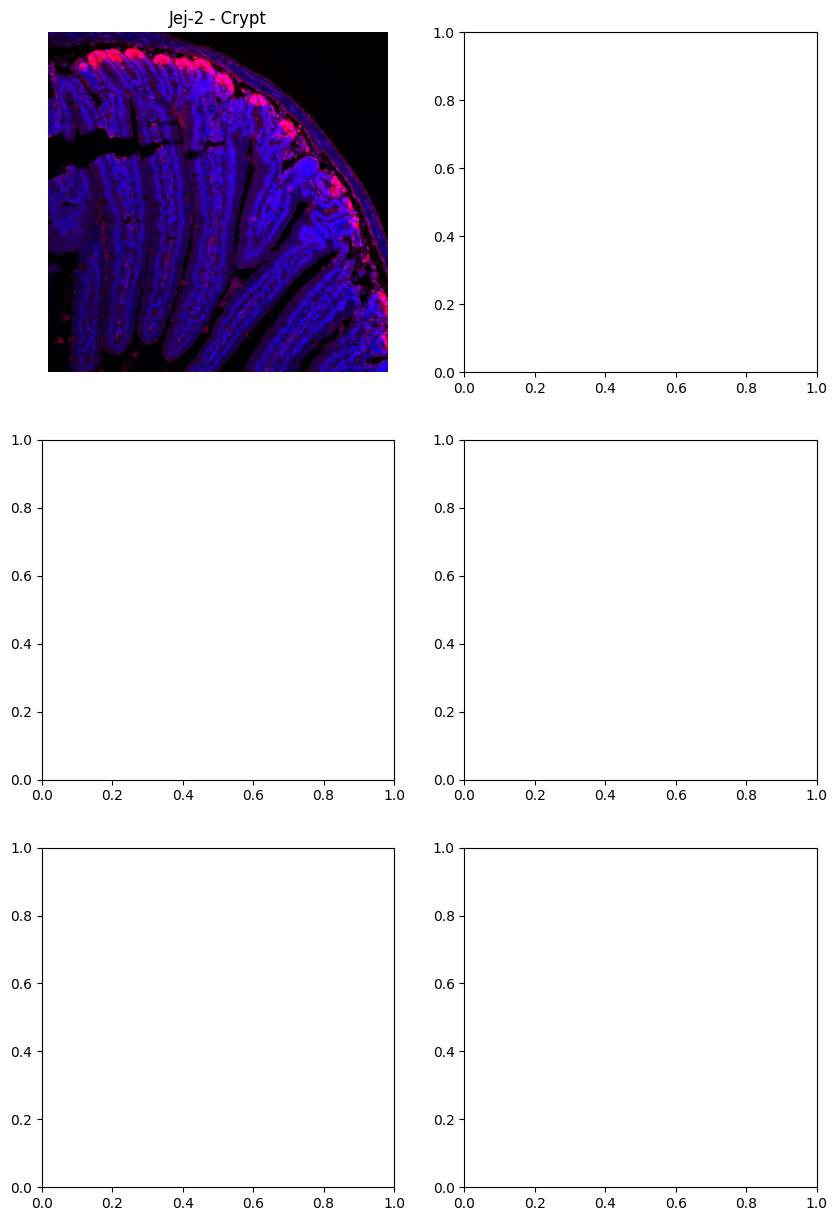

/home/phillip/documents/lysozyme/.venv/lib/python3.12/site-packages/dask/array/core.py:5084: RuntimeWarning: invalid value encountered in divide
  result = function(*args, **kwargs)
/home/phillip/documents/lysozyme/.venv/lib/python3.12/site-packages/dask/array/core.py:5084: RuntimeWarning: invalid value encountered in divide
  result = function(*args, **kwargs)
/home/phillip/documents/lysozyme/.venv/lib/python3.12/site-packages/dask/array/core.py:5084: RuntimeWarning: invalid value encountered in divide
  result = function(*args, **kwargs)
/home/phillip/documents/lysozyme/.venv/lib/python3.12/site-packages/dask/array/core.py:5084: RuntimeWarning: invalid value encountered in divide
  result = function(*args, **kwargs)


In [14]:
## visualize
scale = 5
width = 2
fig, ax = plt.subplots(len(list_of_images_to_try),width, figsize=(scale*width, len(list_of_images_to_try)*scale))
for i, image_set in enumerate(list_of_images_to_try):

    subject, crypt_img, tissue_img = image_set
    crypt_img, tissue_img = minmax(crypt_img), minmax(tissue_img)
    ax[i,0].imshow(
        np.stack(
            [crypt_img, np.zeros_like(crypt_img), tissue_img], 
            axis=-1)
            ); ax[i,0].axis('off'); ax[i,0].set_title(f"{subject} - Crypt")
    ax[i,1].imshow(label2rgb(identify_crypt_seeds(crypt_img, tissue_img))); ax[i,1].axis('off'); ax[i,1].set_title(f"{subject} - crypt seeds")
    #ax[i,2].imshow(label2rgb(identify_potential_crypts_old_like(crypt_img, tissue_img)), cmap='nipy_spectral'); ax[i,2].axis('off'); ax[i,2].set_title(f"{subject} - Old identify potential crypts")
    #ax[i,2].imshow(identify_potential_crypts(crypt_img, tissue_img, debug=False), cmap='nipy_spectral'); ax[i,2].axis('off'); ax[i,2].set_title(f"{subject} - Segmented Crypts")
    #ax[i,3].imshow(label2rgb(old_identify_potential_crypts(crypt_img, tissue_img, debug=False)), cmap='nipy_spectral'); ax[i,3].axis('off'); ax[i,3].set_title(f"{subject} - Old Segmented Crypts")
fig.show()

# integration

In [8]:
from __future__ import annotations
from typing import Optional, Dict, Any, Tuple

import numpy as np
import cv2

from scipy.ndimage import label as ndi_label, distance_transform_edt
from skimage.morphology import (
    binary_erosion, remove_small_objects, disk, dilation, opening, local_maxima
)
from skimage.segmentation import expand_labels, watershed
from skimage.exposure import equalize_adapthist
from skimage.measure import label as sk_label


# ---------------------------- utilities ----------------------------

def to_float01(img: np.ndarray) -> np.ndarray:
    """Return an array scaled to [0,1] float without modifying NaNs/Inf."""
    if img.dtype == np.float32 or img.dtype == np.float64:
        # assume already roughly 0-1; just clip
        return np.clip(img, 0.0, 1.0)
    if np.issubdtype(img.dtype, np.integer):
        info = np.iinfo(img.dtype)
        return np.clip(img.astype(np.float32) / float(info.max), 0.0, 1.0)
    # fallback
    arr = img.astype(np.float32)
    # robust scale
    lo, hi = np.nanpercentile(arr, [0.5, 99.5])
    if hi > lo:
        arr = (arr - lo) / (hi - lo)
    return np.clip(arr, 0.0, 1.0)


def minmax(x: np.ndarray) -> np.ndarray:
    """Normalize an array to [0,1] (safe if constant)."""
    x = x.astype(np.float32, copy=False)
    lo, hi = np.nanmin(x), np.nanmax(x)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return np.zeros_like(x, dtype=np.float32)
    return (x - lo) / (hi - lo)


def _odd(n: int) -> int:
    return n if n % 2 == 1 else n + 1


# ---------------------------- “new” pieces ----------------------------

def caps(image: np.ndarray, small_r: int, big_r: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Contrast-adaptive ‘cap’ decomposition (all in 0–1 floats)."""
    image = to_float01(image)
    # strengthen local contrast in a way that preserves 0–1
    img1 = to_float01(image - 0.0)  # no-op but keeps intent clear
    img1 = equalize_adapthist(img1, clip_limit=0.01)

    hats = dilation(img1, disk(big_r)) - dilation(img1, disk(small_r))
    hats = minmax(hats)

    clean = img1 - np.minimum(img1, hats)
    clean = minmax(clean)

    troughs = np.maximum(img1, hats) - img1
    troughs = minmax(troughs)
    return hats, clean, troughs


def identify_crypt_seeds_new(
    crypt_img: np.ndarray,
    tissue_image: np.ndarray,
) -> np.ndarray:
    """
    Your newer seed logic (works great when crypts are more solid).
    Returns a labeled seed image (0 == background).
    """
    crypt_img = to_float01(crypt_img)
    tissue_image = to_float01(tissue_image)

    tissue_hats, tissue_clean, tissue_troughs = caps(tissue_image, 1, 40)
    crypt_hats,  crypt_clean,  crypt_troughs  = caps(crypt_img,    2, 40)

    thinned_crypts = np.maximum(crypt_clean - tissue_clean, 0)
    split_crypts   = np.maximum(crypt_clean - tissue_troughs, 0)

    good_crypts = minmax(
        opening(split_crypts * thinned_crypts, footprint=disk(5)) ** 0.5
    )

    distance = tissue_troughs - good_crypts
    maxi = local_maxima(good_crypts)
    seeds = watershed(distance, markers=maxi, mask=(tissue_troughs < good_crypts))
    seeds = sk_label(seeds > 0)
    return seeds


# ---------------------------- “old” pipeline (refactored) ----------------------------

def identify_potential_crypts_old_like(
    crypt_img: np.ndarray,
    tissue_image: np.ndarray,
    blob_size_px: Optional[int] = 30,
    external_crypt_seeds: Optional[np.ndarray] = None,
) -> np.ndarray:
    """
    Original watershed skeleton, with the option to inject external crypt seeds.
    Returns final crypt labels (0 == background).
    """
    crypt_img = to_float01(crypt_img)
    tissue_image = to_float01(tissue_image)

    if crypt_img.shape != tissue_image.shape:
        raise ValueError(f"Image shape mismatch: red {crypt_img.shape} vs blue {tissue_image.shape}")

    effective_blob = float(blob_size_px) if blob_size_px else 1.0
    erosion_dim = _odd(max(3, int(round(effective_blob / 10.0))))
    erosion_footprint = np.ones((erosion_dim, erosion_dim), dtype=bool)

    # --- crypt seeds (either original logic or external) ---
    if external_crypt_seeds is None:
        # original tight crypt seeds
        crypt_seeds_bool = crypt_img > np.minimum(tissue_image, crypt_img)
        min_region_area = max(20, int(round((effective_blob ** 2) / 16.0)))
        crypt_seeds_bool = binary_erosion(crypt_seeds_bool, footprint=erosion_footprint)
        crypt_seeds_bool = remove_small_objects(crypt_seeds_bool, min_size=min_region_area)
        labeled_diff_r, _ = ndi_label(crypt_seeds_bool)
    else:
        # trust given seeds but clean a bit
        external_crypt_seeds = external_crypt_seeds.astype(np.int32)
        crypt_seed_mask = external_crypt_seeds > 0
        min_region_area = max(20, int(round((effective_blob ** 2) / 16.0)))
        crypt_seed_mask = remove_small_objects(crypt_seed_mask, min_size=min_region_area)
        # relabel to be dense 1..N
        labeled_diff_r = sk_label(crypt_seed_mask)

    # --- eroded tissue (mask_gt_red from original) ---
    abs_diff = np.maximum(tissue_image - crypt_img, 0)
    mask_gt_red = abs_diff > crypt_img  # non-crypt tissue proxy

    erosion_kernel_size = max(3, int(round(effective_blob * 0.15)))
    erosion_kernel_size = erosion_kernel_size if erosion_kernel_size % 2 == 0 else erosion_kernel_size + 1
    cv_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (erosion_kernel_size, erosion_kernel_size))
    mask_u8 = (mask_gt_red.astype(np.uint8) * 255)
    erosion_iterations = max(1, int(round(effective_blob / 20.0)))
    mask_eroded_u8 = cv2.erode(mask_u8, cv_kernel, iterations=erosion_iterations)
    tissue_eroded = mask_eroded_u8.astype(bool)

    # --- build combined labels for expand + elevation ---
    combined_labels = np.zeros_like(labeled_diff_r, dtype=int)
    combined_labels[tissue_eroded] = 2  # tissue
    combined_labels[labeled_diff_r > 0] = 1  # crypt seed class

    expand_distance = max(1, int(round(effective_blob * 2.5)))
    expanded_labels = expand_labels(combined_labels, distance=expand_distance)

    # rework markers: 1(tissue)->background, crypts get unique indices
    reworked = np.zeros_like(expanded_labels, dtype=np.int32)
    reworked[expanded_labels == 2] = 1
    mask_copy = (expanded_labels != 2) & (labeled_diff_r != 0)
    reworked[mask_copy] = labeled_diff_r[mask_copy] + 1  # shift by 1 so tissue can be 1

    mask_ws = expanded_labels > 0

    elevation = (
        minmax(distance_transform_edt(combined_labels == 2))
        - minmax(distance_transform_edt(combined_labels == 1))
    )

    ws_labels = watershed(elevation, markers=reworked, mask=mask_ws)

    # post: set tissue back to background 0, shift crypt ids down
    ws_labels = ws_labels.copy()
    ws_labels[ws_labels == 1] = 0
    ws_labels[ws_labels > 1] -= 1
    return ws_labels.astype(np.int32)


# ---------------------------- hybrid wrapper ----------------------------

def _seed_health_metrics(seed_labels: np.ndarray) -> Dict[str, Any]:
    """Compute basic metrics to judge seed quality."""
    if seed_labels is None or seed_labels.size == 0:
        return dict(n_labels=0, coverage=0.0, mean_area=0.0)
    n_labels = int(seed_labels.max())
    coverage = float(np.count_nonzero(seed_labels)) / seed_labels.size
    if n_labels > 0:
        # quick area estimate by bincount (skip 0)
        areas = np.bincount(seed_labels.ravel())[1:]
        mean_area = float(areas.mean()) if areas.size else 0.0
    else:
        mean_area = 0.0
    return dict(n_labels=n_labels, coverage=coverage, mean_area=mean_area)


def identify_potential_crypts_hybrid(
    crypt_img: np.ndarray,
    tissue_image: np.ndarray,
    blob_size_px: Optional[int] = 30,
    use_new_seeds: bool = True,
    auto_fallback: bool = True,
    min_seed_count: int = 10,
    min_coverage: float = 0.002,  # 0.2%
    debug: bool = False,
) -> Tuple[np.ndarray, Dict[str, Any]]:
    """
    Hybrid pipeline:
      1) Try the new seed generator (great when crypts are solid).
      2) Optionally fall back to original seed logic if new seeds look weak.
      3) Run the (refactored) original watershed body with the chosen seeds.

    Returns:
      labels, debug_info
    """
    crypt_img = to_float01(crypt_img)
    tissue_image = to_float01(tissue_image)

    dbg: Dict[str, Any] = {}

    # (A) propose seeds via new method
    new_seeds = identify_crypt_seeds_new(crypt_img, tissue_image) if use_new_seeds else None
    new_metrics = _seed_health_metrics(new_seeds if new_seeds is not None else np.zeros_like(crypt_img, int))
    dbg["new_seed_metrics"] = new_metrics

    # Decide whether to use new seeds
    use_new = use_new_seeds
    if auto_fallback and use_new_seeds:
        # crude but effective health checks
        use_new = (new_metrics["n_labels"] >= min_seed_count) and (new_metrics["coverage"] >= min_coverage)

    dbg["using_new_seeds"] = bool(use_new)

    if use_new:
        labels = identify_potential_crypts_old_like(
            crypt_img,
            tissue_image,
            blob_size_px=blob_size_px,
            external_crypt_seeds=new_seeds,
        )
        dbg["mode"] = "old_body_with_new_seeds"
    else:
        labels = identify_potential_crypts_old_like(
            crypt_img,
            tissue_image,
            blob_size_px=blob_size_px,
            external_crypt_seeds=None,  # original seed logic
        )
        dbg["mode"] = "old_body_with_old_seeds"

    if debug:
        dbg["labels_max"] = int(labels.max())
        dbg["labels_coverage"] = float(np.count_nonzero(labels)) / labels.size

    return labels, dbg


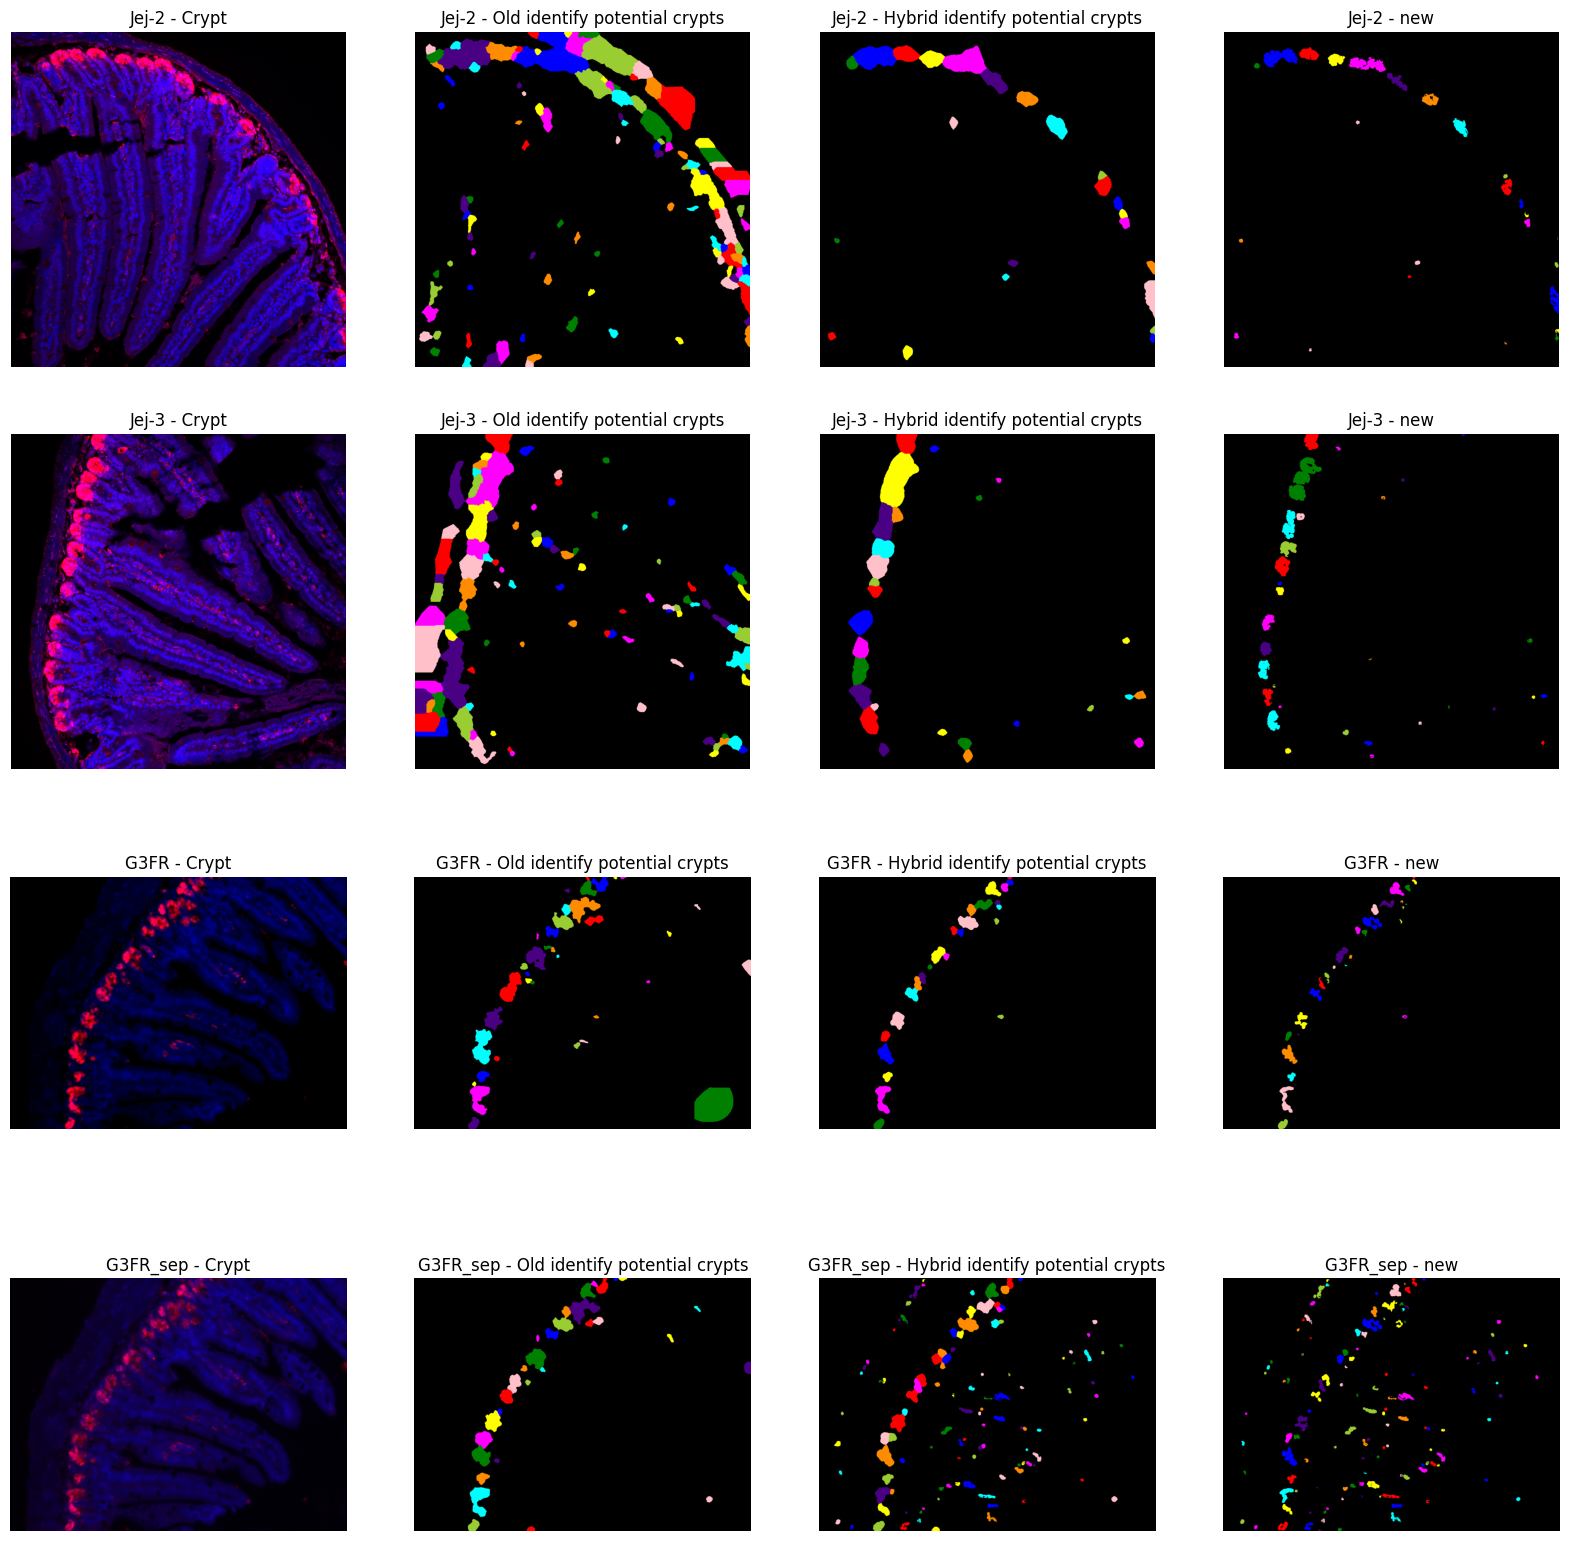

In [9]:
scale = 5
width = 4
fig, ax = plt.subplots(len(list_of_images_to_try),width, figsize=(scale*width, len(list_of_images_to_try)*scale))
for i, image_set in enumerate(list_of_images_to_try):

    subject, crypt_img, tissue_img = image_set
    crypt_img, tissue_img = minmax(crypt_img), minmax(tissue_img)
    ax[i,0].imshow(
        np.stack(
            [crypt_img, np.zeros_like(crypt_img), tissue_img], 
            axis=-1)
            ); ax[i,0].axis('off'); ax[i,0].set_title(f"{subject} - Crypt")
    ax[i,1].imshow(label2rgb(identify_potential_crypts_old_like(crypt_img, tissue_img))); ax[i,1].axis('off'); ax[i,1].set_title(f"{subject} - Old identify potential crypts")
    ax[i,2].imshow(label2rgb(identify_potential_crypts_hybrid(crypt_img, tissue_img)[0]), cmap='nipy_spectral'); ax[i,2].axis('off'); ax[i,2].set_title(f"{subject} - Hybrid identify potential crypts")
    #ax[i,2].imshow(identify_potential_crypts(crypt_img, tissue_img, debug=False), cmap='nipy_spectral'); ax[i,2].axis('off'); ax[i,2].set_title(f"{subject} - Segmented Crypts")
    ax[i,3].imshow(label2rgb(identify_crypt_seeds_new(crypt_img, tissue_img)), cmap='nipy_spectral'); ax[i,3].axis('off'); ax[i,3].set_title(f"{subject} - new")
fig.show()